# Simple example of using the transmission_models library

In [1]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.stats import nbinom, gamma, binom, expon
from math import factorial
import time

import os,sys


In [2]:
import transmission_models as tmod
from transmission_models.utils import hierarchy_pos,hierarchy_pos_times,plot_transmision_network,tree_to_newick,search_firsts_sampled_siblings
from transmission_models import didelot_unsampled as du
import transmission_models.utils as utils
from transmission_models.utils.topology_movements import *

# 1. Loading parameters

First, initialize the parameters of the model and the model

In [3]:
sampling_params = {
                    "pi":0.47,
                    "k_samp":5.316,
                    "theta_samp":1.158
                }
offspring_params = {
                    "r":4.47,
                    "p_inf":0.62,
                }
infection_params = {
                    "k_inf": 5.70959959960973,
                    "theta_inf":1.061661377840768
                }

In [4]:
# Creating the model
model = du(sampling_params, offspring_params, infection_params)

# 2. Loading data

Second, load your datasets and generate a list of `host`.

In [5]:
data_dir = "../data"
df = pd.read_csv(data_dir+"/49_nodes_icpmr_delta_gisaid.csv")
df['date_collection'] = pd.to_datetime(df['date_collection'])
df['date_submitted'] = pd.to_datetime(df['date_submitted'])
df["date_sample"] = (df["date_collection"]-df['date_collection'].min()).dt.days
df["t_inf_ini"] = df.apply(lambda row:row.date_sample-gamma.rvs(infection_params["k_inf"], loc=0, scale=infection_params["theta_inf"], size=1)[0] ,
                                       axis = 1)




In [6]:
# Generate a list of hosts from the dataframe
data = []
for i, h in enumerate(df.iloc):
    host = tmod.host(h.strain, i, t_sample=h.date_sample, t_inf=h.t_inf_ini)
    data.append(host)

# 3. Generating initial condition network

You have to initialize a `nx.DiGraph` tree network in the model by using `set_T` method. You can create your own network or use one of the functions to create a new one. 

In [7]:
# Creating a network given a list of hosts
T = tmod.utils.build_infection_based_network(model, data)

model.set_T(T)

### Other funtions to generate predefined networks layouts

There are three predefined tree networks layouts, all with an unsampled host as root host:

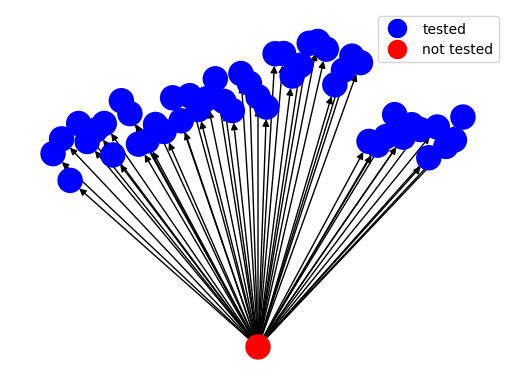

In [8]:
T = tmod.utils.build_infection_offspring_based_network(model, data)
pos = tmod.utils.hierarchy_pos_times(T)

tmod.utils.plot_transmision_network(T,pos=pos)



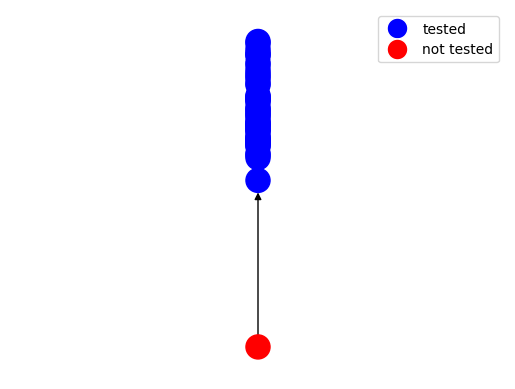

In [9]:
T = tmod.utils.build_infection_chain_based_network(model, data)
pos = tmod.utils.hierarchy_pos_times(T)

tmod.utils.plot_transmision_network(T,pos=pos)



# MCMC with no location and genetic information

Now you can run a MCMC and start sampling networks 

In [11]:
# Set up MCMC sampling parameters
# N_burn: Number of initial iterations to discard (burn-in period)
# N_measure: Interval between measurements for collecting samples
# N_iter: Total number of iterations


N_burn = 2000
N_measure = 1000
N_iter = 20000

log_posteriors = []
N_trees = []
N_unsampleds = []

mcmc = tmod.MCMC(model)

for itt in range(N_iter):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration(verbose=False)
    if itt>N_burn and itt%N_measure==0:
        log_posteriors.append(model.log_posterior_transmission_tree())
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
        print(f"Iteration {itt}: log_posterior={log_posteriors[-1]:.3f}, unsampled_hosts={len(model.unsampled_hosts)}, trees={len(search_firsts_sampled_siblings(model.root_host,model.T))}")

    
    
# Saving the model to later use it or visualize it
model.save_json("model_simple.json")
    

Iteration 3000: log_posterior=622.669, unsampled_hosts=23, trees=14
Iteration 4000: log_posterior=635.073, unsampled_hosts=19, trees=16
Iteration 5000: log_posterior=626.537, unsampled_hosts=20, trees=15
Iteration 6000: log_posterior=624.841, unsampled_hosts=21, trees=17
Iteration 7000: log_posterior=639.360, unsampled_hosts=16, trees=15
Iteration 8000: log_posterior=620.888, unsampled_hosts=20, trees=20
Iteration 9000: log_posterior=652.655, unsampled_hosts=16, trees=16
Iteration 10000: log_posterior=649.227, unsampled_hosts=17, trees=17
Iteration 11000: log_posterior=626.293, unsampled_hosts=23, trees=13
Iteration 12000: log_posterior=651.395, unsampled_hosts=17, trees=10
Iteration 13000: log_posterior=669.242, unsampled_hosts=13, trees=10
Iteration 14000: log_posterior=672.982, unsampled_hosts=11, trees=8
Iteration 15000: log_posterior=643.626, unsampled_hosts=18, trees=5
Iteration 16000: log_posterior=672.199, unsampled_hosts=10, trees=7
Iteration 17000: log_posterior=678.747, unsa

Text(0.5, 0, 'log_posterior')

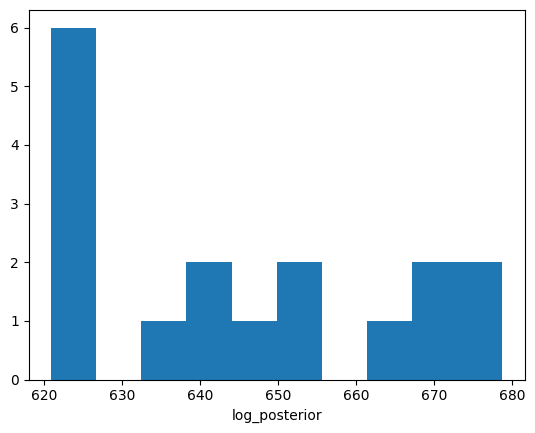

In [12]:
plt.hist(log_posteriors)
plt.xlabel("log_posterior")

Text(0.5, 0, 'Number of trees')

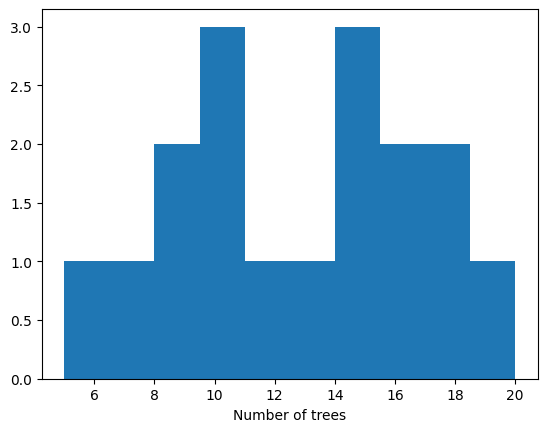

In [13]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

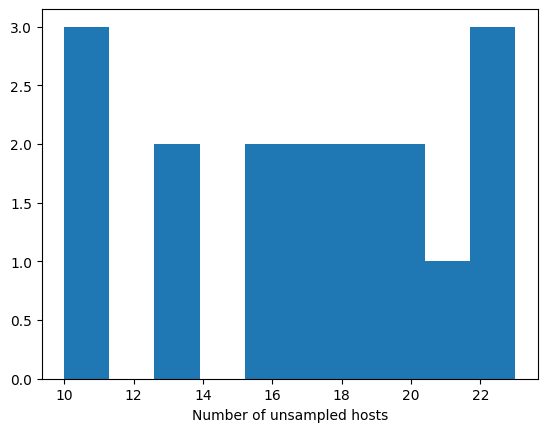

In [14]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

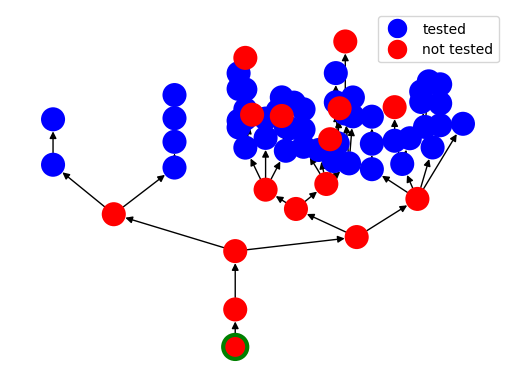

In [15]:
pos = hierarchy_pos_times(model.T, width=1., vert_gap=0.2, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos,highlighted_nodes=[model.root_host])

# MCMC with location information

To add location to the model you need a 2d array indexed with the id of the hosts and add it to the model with the `add_same_location_prior` method.

In [16]:
# Creating the 2d array of distances between hosts
dist_df = pd.read_csv("../data/location_49_hosts.tsv",sep="\t", index_col="strain_x")


dist_loc = np.zeros((len(model.T),len(model.T)))
i=0
for h in model.T:
    if not h.sampled: continue
    if str(h) not in dist_df.index:
            dist_loc[int(h), :] = None
            dist_loc[:,int(h)] = None
            continue
    for h2 in model.T[h]:
        if str(h2) not in dist_df.index:
            dist_loc[int(h2), :] = None
            dist_loc[:,int(h2)] = None
            continue
        if not h2.sampled: continue
        i+=1
        dist_loc[int(h),int(h2)] = dist_df.loc[str(h),str(h2)]
        dist_loc[int(h2),int(h)] = dist_df.loc[str(h2),str(h)]

# Adding the location to the model
model.add_same_location_prior(0.1,15,dist_loc)
model.same_location_log_prior = model.same_location_prior.log_prior_T(model.T)


In [17]:
mcmc = tmod.MCMC(model)
# Set up MCMC sampling parameters
# N_burn: Number of initial iterations to discard (burn-in period)
# N_measure: Interval between measurements for collecting samples
# N_iter: Total number of iterations

N_burn = 2000
N_measure = 100
N_iter = 20000

log_posteriors = []
N_trees = []
N_unsampleds = []

for itt in range(N_iter):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_posteriors.append(model.log_posterior_transmission_tree())
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
       
        print(f"Iteration {itt}: log_posterior={log_posteriors[-1]:.3f}, unsampled_hosts={len(model.unsampled_hosts)}, trees={len(search_firsts_sampled_siblings(model.root_host,model.T))}")

    
    
# Saving the model to later use it or visualize it
model.save_json("model_location.json")

Iteration 2100: log_posterior=578.649, unsampled_hosts=14, trees=14
Iteration 2200: log_posterior=565.273, unsampled_hosts=17, trees=14
Iteration 2300: log_posterior=596.081, unsampled_hosts=11, trees=14
Iteration 2400: log_posterior=562.073, unsampled_hosts=17, trees=14
Iteration 2500: log_posterior=561.625, unsampled_hosts=18, trees=12
Iteration 2600: log_posterior=563.675, unsampled_hosts=17, trees=13
Iteration 2700: log_posterior=573.659, unsampled_hosts=15, trees=11
Iteration 2800: log_posterior=577.213, unsampled_hosts=14, trees=12
Iteration 2900: log_posterior=567.300, unsampled_hosts=15, trees=13
Iteration 3000: log_posterior=544.030, unsampled_hosts=19, trees=13
Iteration 3100: log_posterior=557.270, unsampled_hosts=17, trees=14
Iteration 3200: log_posterior=536.937, unsampled_hosts=21, trees=10
Iteration 3300: log_posterior=533.051, unsampled_hosts=21, trees=10
Iteration 3400: log_posterior=534.310, unsampled_hosts=22, trees=10
Iteration 3500: log_posterior=516.529, unsampled

Text(0.5, 0, 'log_posterior')

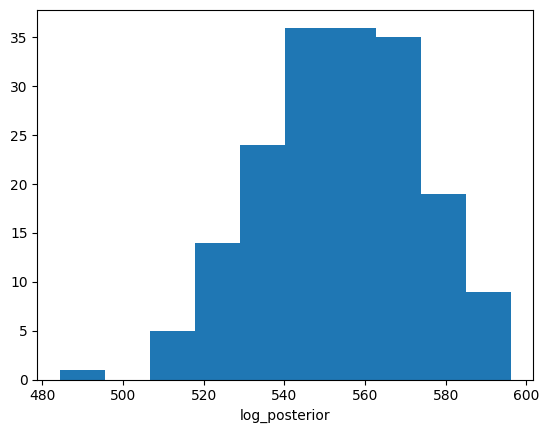

In [18]:
plt.hist(log_posteriors)
plt.xlabel("log_posterior")

Text(0.5, 0, 'Number of trees')

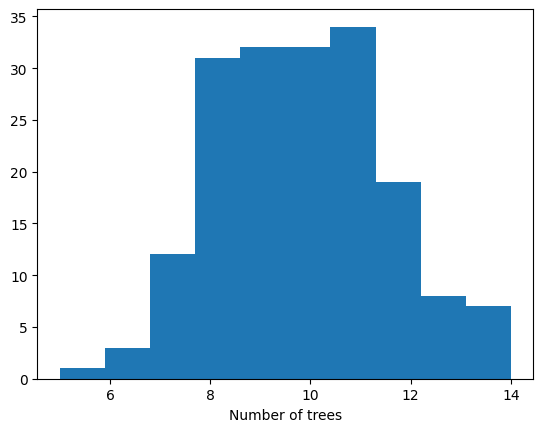

In [19]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

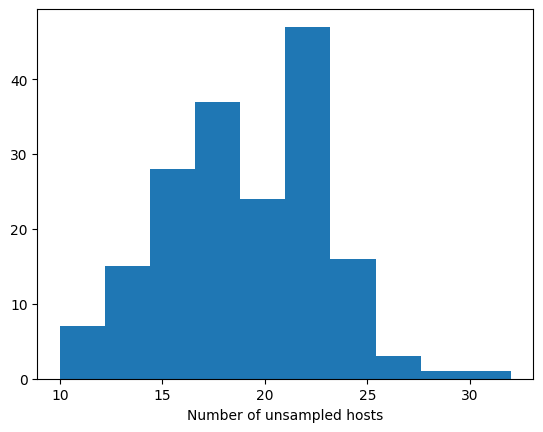

In [20]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

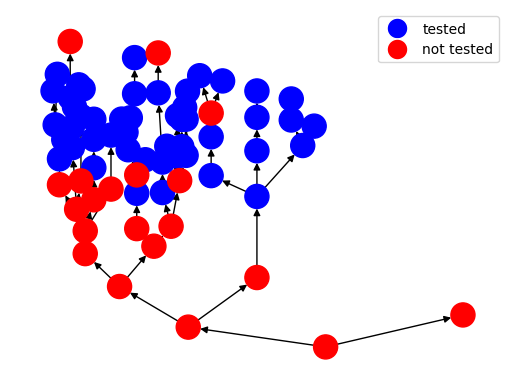

In [21]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)

# MCMC with genetic information

To add genetic information to the model you need a 2d array indexed with the id of the hosts and add it to the model with the `add_sgenetic_prior` method.

In [22]:
data_dir = "../data/genetic_49_hosts.tsv"
dist_df = pd.read_csv(data_dir,sep="\t",index_col=0)
dist_gen = np.zeros((len(model.T),len(model.T)))
i = 0
for h in model.T:
    if not h.sampled: continue
    for h2 in model.T[h]:
        if not h2.sampled: continue
        i+=1
        print(i,h,h2)
        dist_gen[int(h),int(h2)] = dist_df.loc[h.id,h2.id]
        dist_gen[int(h2),int(h)] = dist_df.loc[h2.id,h.id]

model.add_genetic_prior(0.1065,dist_gen)
model.genetic_log_prior = model.genetic_prior.log_prior_T(model.T)

1 hCoV-19/Australia/NSW1649/2021 hCoV-19/Australia/NSW1727/2021
2 hCoV-19/Australia/NSW1649/2021 hCoV-19/Australia/NSW1657/2021
3 hCoV-19/Australia/NSW1678/2021 hCoV-19/Australia/NSW1768/2021
4 hCoV-19/Australia/NSW1678/2021 hCoV-19/Australia/NSW1761/2021
5 hCoV-19/Australia/NSW1666/2021 hCoV-19/Australia/NSW1762/2021
6 hCoV-19/Australia/NSW1666/2021 hCoV-19/Australia/NSW1667/2021
7 hCoV-19/Australia/NSW1666/2021 hCoV-19/Australia/NSW1773/2021
8 hCoV-19/Australia/NSW1677/2021 hCoV-19/Australia/NSW1668/2021
9 hCoV-19/Australia/NSW1655/2021 hCoV-19/Australia/NSW1708/2021
10 hCoV-19/Australia/NSW1655/2021 hCoV-19/Australia/NSW1680/2021
11 hCoV-19/Australia/NSW1634/2021 hCoV-19/Australia/NSW1677/2021
12 hCoV-19/Australia/NSW1662/2021 hCoV-19/Australia/NSW1739/2021
13 hCoV-19/Australia/NSW1664/2021 hCoV-19/Australia/NSW1738/2021
14 hCoV-19/Australia/NSW1665/2021 hCoV-19/Australia/NSW1729/2021
15 hCoV-19/Australia/NSW1665/2021 hCoV-19/Australia/NSW1663/2021
16 hCoV-19/Australia/NSW1665/2021 

In [23]:
mcmc = tmod.MCMC(model)
# Set up MCMC sampling parameters
# N_burn: Number of initial iterations to discard (burn-in period)
# N_measure: Interval between measurements for collecting samples
# N_iter: Total number of iterations

N_burn = 200
N_measure = 10
N_iter = 2000

log_posteriors = []
N_trees = []
N_unsampleds = []

for itt in range(N_iter):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_posteriors.append(model.log_posterior_transmission_tree())
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
       
        print(f"Iteration {itt}: log_posterior={log_posteriors[-1]:.3f}, unsampled_hosts={len(model.unsampled_hosts)}, trees={len(search_firsts_sampled_siblings(model.root_host,model.T))}")

    
    
# Saving the model to later use it or visualize it
model.save_json("model_genetic.json")

Iteration 210: log_posterior=479.608, unsampled_hosts=24, trees=13
Iteration 220: log_posterior=485.764, unsampled_hosts=23, trees=13
Iteration 230: log_posterior=488.808, unsampled_hosts=23, trees=13
Iteration 240: log_posterior=486.741, unsampled_hosts=23, trees=13
Iteration 250: log_posterior=484.430, unsampled_hosts=23, trees=13
Iteration 260: log_posterior=484.430, unsampled_hosts=23, trees=13
Iteration 270: log_posterior=478.516, unsampled_hosts=24, trees=13
Iteration 280: log_posterior=482.966, unsampled_hosts=23, trees=13
Iteration 290: log_posterior=479.809, unsampled_hosts=24, trees=13
Iteration 300: log_posterior=484.807, unsampled_hosts=23, trees=13
Iteration 310: log_posterior=484.355, unsampled_hosts=23, trees=13
Iteration 320: log_posterior=478.988, unsampled_hosts=24, trees=13
Iteration 330: log_posterior=482.117, unsampled_hosts=24, trees=13
Iteration 340: log_posterior=482.283, unsampled_hosts=24, trees=13
Iteration 350: log_posterior=473.495, unsampled_hosts=26, tree

Text(0.5, 0, 'log_posteriors')

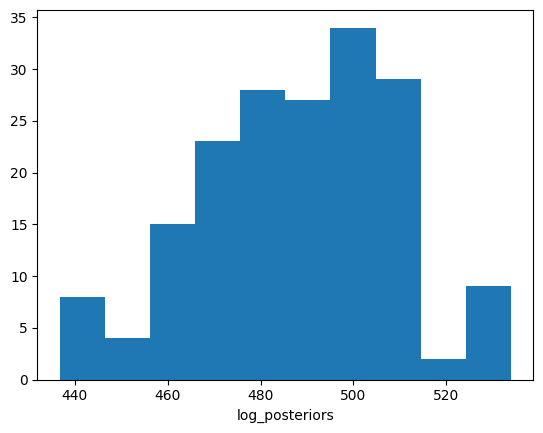

In [29]:
plt.hist(log_posteriors)
plt.xlabel("log_posteriors")

Text(0.5, 0, 'Number of trees')

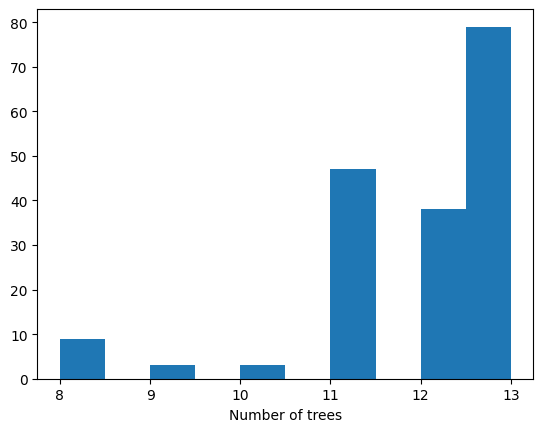

In [30]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

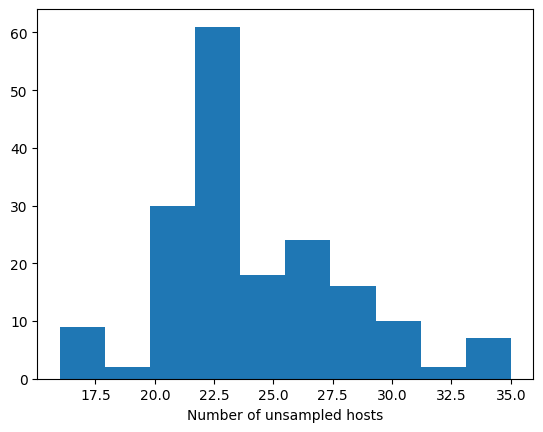

In [26]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

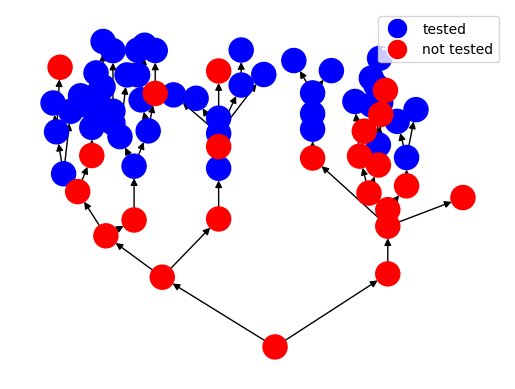

In [31]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)

# Load jsons with trained models

You can load jsons to continue runing the MCMC, analyze it or visualize it in the https://www.maths.usyd.edu.au/u/oscarf/tree_layout/ webpage

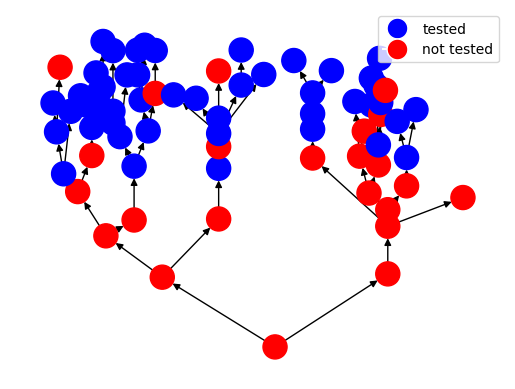

In [28]:
import transmission_models as tmod
from transmission_models import didelot_unsampled as du
from transmission_models.utils import hierarchy_pos_times

# Loading the genetic model
genetic_model = du.json_to_tree("model_genetic.json")

pos = hierarchy_pos_times(genetic_model.T, root=genetic_model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(genetic_model.T,pos=pos)


![Figure: Example of a tree layout visualization generated in https://www.maths.usyd.edu.au/u/oscarf/tree_layout/.](Screenshot%202025-07-30%20at%2015-49-21%20Tree%20layout.png)
Figure: Example of a tree layout visualization generated in https://www.maths.usyd.edu.au/u/oscarf/tree_layout/.



